# Basic CNN with Tensorflow
by Van-Dat Thang

## Content
### 1. CNN definitions
### 2. CNN in tensorflow
### 3. Example

1. Train [VGG16](https://arxiv.org/abs/1409.1556) Deep Neural Network with [Cifar100](https://www.cs.toronto.edu/~kriz/cifar.html) dataset

# CNN definitions

![Convolutional Neural Network](./images_presentation/CNNs.png)

[Definition](https://en.wikipedia.org/wiki/Convolutional_neural_network): In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery.




![fullyConnected vs Convolution Layer](images_presentation/fullyConnectedvsConvolutionLayer.png)


## convolutional kernel

![convolutional_kernel](images_presentation/convolutionnal_kernel.png)

1. A convolutional kernel is applied to inputs. The kernel weights are multiplied
elementwise with the corresponding numbers in the local receptive field and the multi‐
plied numbers are summed. Note that this corresponds to a convolutional layer without
a nonlinearity.
2. [handel multi-channels version](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

## Pooling Layers

![pooling](images_presentation/Pooling_Layers.png)


# CNN APIs in Tensorflow

# Example (Train [VGG16](https://arxiv.org/abs/1409.1556) Deep Neural Network with [Cifar100](https://www.cs.toronto.edu/~kriz/cifar.html) dataset)


1. Load [Cifar100](https://www.cs.toronto.edu/~kriz/cifar.html) dataset
2. Create [TFRecord files](https://www.tensorflow.org/tutorials/load_data/tf_records) files and saved to hardisk
    [1](https://www.damienpontifex.com/2017/09/18/convert-and-using-the-mnist-dataset-as-tfrecords/)
3. Implement [VGG16](https://arxiv.org/abs/1409.1556) model
4. Train [VGG16](https://arxiv.org/abs/1409.1556) model with [TFRecord files](https://www.tensorflow.org/tutorials/load_data/tf_records)
5. Validate result

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf    # tensorflow library
import numpy as np         # numpy library
import cv2 as cv          # opencv library
import sys
import os
from tqdm import tqdm
from urllib.request import urlretrieve
import tarfile
import pickle
import matplotlib.pyplot as plt

print("tensorflow: {}".format(tf.__version__))
print("opencv: {}".format(cv.__version__))

tensorflow: 1.13.1
opencv: 4.1.0


In [2]:
def my_hook(t):
    """
    Wraps tqdm instance
    :param t:
    :return:
    """
    last_b = [0]

    def inner(b=1, bsize=1, tsize=None):
        """

        :param b:       int option
        :param bsize:   int
        :param tsize:
        :return:
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return inner

<b> Class cifar100 will return test and train data set with 100 classes </b>

In [3]:
class cifar100:
    def __init__(self, cifar100_dir=None):
        self.name = "Cifar100 dataset"
        self.n_channels = 3
        self.width = 32
        self.heigh = 32
        self.DIR = "./cifar100_dataset"
        if os.path.isdir(self.DIR) == False:
            os.mkdir(self.DIR)


        cifar100_url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
            
        name = cifar100_url.split("/")
        name = name[len(name) - 1]

        full_file_path = os.path.join(self.DIR, name)

        if os.path.isfile(full_file_path) == False:
            print("downloading from: {}".format(cifar100_url))
            with tqdm(unit="B", unit_scale=True, leave=True, miniters=1, desc=cifar100_url.split("/")[-1]) as t:
                urlretrieve(cifar100_url, filename=full_file_path, reporthook=my_hook(t), data=None)
            print("finish download")

        # extract compressed file
        tar = tarfile.open(full_file_path)
        sub_folders = tar.getnames()
        train_subfolder = [f for f in sub_folders if os.path.split(f)[1] == "train"]
        self._train_subfolder = train_subfolder[0]
        test_subfolder = [f for f in sub_folders if os.path.split(f)[1] == "test"]
        self._test_subfolder = test_subfolder[0]
        tar.extractall()
        tar.close()

    def get_data(self):

        with open(self._train_subfolder, 'rb') as fo:
            try:
                self.samples_train = pickle.load(fo)
            except UnicodeDecodeError:  # python 3.x
                fo.seek(0)
                self.samples_train = pickle.load(fo, encoding='latin1')

        with open(self._test_subfolder, 'rb') as fo:
            try:
                self.samples_test = pickle.load(fo)
            except UnicodeDecodeError:
                fo.seek(0)
                self.samples_test = pickle.load(fo, encoding='latin1')

        train_data_img = self.samples_train["data"]
        train_data_labels = self.samples_train["fine_labels"]
        test_data_img = self.samples_test["data"]
        test_data_lables = self.samples_test["fine_labels"]

        return (train_data_img, train_data_labels), (test_data_img, test_data_lables)

In [4]:
dataset = cifar100()
(train_data_img, train_data_labels), (test_data_img, test_data_labels) = dataset.get_data()
train_img_number = len(train_data_img)
test_img_number = len(test_data_img)
print(dataset.name)
print("Number of Images in train set: {}".format(train_img_number))
print("Number of Images in test set: {}".format(test_img_number))
print("{}".format(train_data_img.shape))
print("Images size: {}x{}x{}".format(dataset.heigh, dataset.width, dataset.n_channels))

Cifar100 dataset
Number of Images in train set: 50000
Number of Images in test set: 10000
(50000, 3072)
Images size: 32x32x3


<b>Convert ''train_data_labels'' and ''test_data_labeols'' to one-hot encoding format</b>

In [5]:
train_data_labels_one_hot = np.zeros((train_img_number, 101))
train_data_labels_one_hot[np.arange(train_img_number), train_data_labels] = 1

test_data_labels_one_hot = np.zeros((test_img_number, 101))
test_data_labels_one_hot[np.arange(test_img_number), test_data_labels] = 1

<b> Check one-hot encoding labels </b>

In [6]:
print(test_data_labels_one_hot)
print(train_data_labels_one_hot)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<b>Check img data</b>

In [7]:
def display_cifar(images, size):
    """
    """
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()

    im = np.vstack([np.hstack([np.reshape(images[np.random.choice(n)], (32,32,3)) for i in range(size)]) for i in range(size)])
    plt.imshow(im)
    plt.savefig("./cifar-100-" + str(n))
    plt.show()

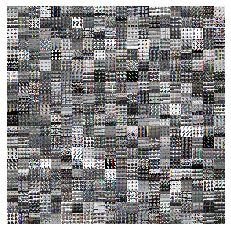

In [8]:
display_cifar(train_data_img[:400], 20)

<b> Get file path directory </b>

In [9]:
ROOT_PATH = os.getcwd()
print(ROOT_PATH)

/home/dat/PycharmProjects/ML-DL-Lecture-Notes/DeepLearning/ipython


## Create TFRecord

In [10]:
cifar100_path = os.path.join(ROOT_PATH, dataset.DIR[2:])
tfrecord_path = os.path.join(cifar100_path, "tfrecord")
if os.path.isdir(tfrecord_path) == False:
    os.mkdir(tfrecord_path)
print(tfrecord_path)

/home/dat/PycharmProjects/ML-DL-Lecture-Notes/DeepLearning/ipython/cifar100_dataset/tfrecord


In [11]:
def wrap_int64(value):
    """
    """
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def wrap_bytes(value):
    """
    """
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


In [12]:
def convert(images, labels, batch_size=32, out_path="./"):
    
    num_images = len(images)
    batch_num = num_images // batch_size
    
    outs = [out_path + "_" + str(batch_id) + ".tfrecord" for batch_id in range(batch_num)]
    i = 0
    for out in tqdm(outs):
        with tf.python_io.TFRecordWriter(out) as writer:
            # Iterate over all the image-paths and class-labels.
            first = i * batch_size
            last = first + batch_size
            img = images[first:last]
            label = labels[first:last]
            # Convert the image to raw bytes.
            img_bytes = img.tostring()
            label_bytes = label.tostring()

            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_bytes(label_bytes)
                }

            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)

            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)

            # Serialize the data.
            serialized = example.SerializeToString()

            # Write the serialized data to the TFRecords file.
            writer.write(serialized)
        i += 1

In [13]:
BACH_SIZE=32
convert(train_data_img, train_data_labels_one_hot, batch_size=BACH_SIZE, out_path=tfrecord_path + "/train")

100%|██████████| 1562/1562 [00:00<00:00, 3152.79it/s]


In [14]:
convert(test_data_img, test_data_labels_one_hot, batch_size=BACH_SIZE, out_path=tfrecord_path + "/test")

100%|██████████| 312/312 [00:00<00:00, 3122.35it/s]


# Input Functions for the Estimator

In [15]:
def parser(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    
    features = {
                'image': tf.FixedLenFeature([], tf.string),
                'label': tf.FixedLenFeature([], tf.int64)
                }
    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)
    
    # Get the image as raw bytes.
    image_raw = parsed_example['image']
    
    # Decode the raw bytes so it becomes a tensor with type.
    image = tf.decode_raw(image_raw, tf.uint8)
    
    # The type is now uint8 but we need it to be float.
    image = tf.cast(image, tf.float32)
    
    # Get the label associated with the image.
    label_raw = parsed_example['label']
    
    # Decode the raw bytes so it becomes a tensor with type.
    label = tf.decode_raw(label_raw, tf.uint8)
    
    return image, label
    

In [16]:
def input_fn(filenames, train, batch_size=32, buffer_size=2048):
    dataset = tf.data.TFRecordDataset(filenames=filenames)
    dataset = dataset.map(parse)
    
    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1
        
    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    dataset = dataset.batch(batch_size)

    # Create an iterator for the dataset and the above modifications.
    iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    x = {'image': images_batch}
    y = labels_batch

    return x, y

In [17]:
def train_input_fn():
    return input_fn(filenames=tfrecord_path + "/train", train=True)

def test_input_fn():
    return input_fn(filenames=tfrecord_path + "/test", train=False)

In [18]:
def VGG16(input_tensor, input_shape=[32, 32, 3], n_class=100, is_training=True):
    print("VGG16")
    if len(input_tensor.shape) < 3:
        input = tf.reshape(input_tensor, shape=[-1, input_shape[0], input_shape[1], input_shape[2]], name="input")
    else:
        input = input_tensor
        
    output = tf.layers.conv2d(input, 64, 3, strides=1, padding='same', activation=tf.nn.relu, name="conv1-1")
    output = tf.layers.conv2d(output, 64, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv1-2")  
    output = tf.layers.max_pooling2d(output, pool_size=2, strides=2, padding="valid", name="pool1")
#     print(output)
    
    output = tf.layers.conv2d(output, 128, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv2-1") 
    output = tf.layers.conv2d(output, 128, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv2-2")
    output = tf.layers.max_pooling2d(output, pool_size=2, strides=2, padding="valid", name="pool2")
#     print(output)
    
    output = tf.layers.conv2d(output, 256, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv3-1")
    output = tf.layers.conv2d(output, 256, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv3-2")
    output = tf.layers.conv2d(output, 256, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv3-3")
    output = tf.layers.max_pooling2d(output, pool_size=2, strides=2, padding="valid", name="pool3")
#     print(output)
    
    output = tf.layers.conv2d(output, 512, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv4-1")
    output = tf.layers.conv2d(output, 512, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv4-2")
    output = tf.layers.conv2d(output, 512, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv4-3")
    output = tf.layers.max_pooling2d(output, pool_size=2, strides=2, padding="valid", name="pool4")
#     print(output)
    
    output = tf.layers.conv2d(output, 512, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv5-1")
    output = tf.layers.conv2d(output, 512, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv5-2")
    output = tf.layers.conv2d(output, 512, 3, strides=(1, 1), padding='same', activation=tf.nn.relu, name="conv5-3")
    output = tf.layers.max_pooling2d(output, pool_size=2, strides=2, padding="valid", name="pool5")
#     print(output)
    
    output_shape = output.shape
    output = tf.reshape(output, shape=[-1, int(output_shape[1] * output_shape[2] * output_shape[3])], name="flatten")
    output = tf.layers.dense(output, 4096, activation=tf.nn.softmax, name="fully1")
    output = tf.layers.dense(output, 4096, activation=tf.nn.softmax, name="fully2")
    output = tf.layers.dense(output, n_class, activation=tf.nn.softmax, name="output")
    
    return output

In [19]:
input_tensor = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name="input")
output = VGG16(input_tensor, [None, 32, 32, 3], n_class=100, is_training=True)
print(output)


VGG16
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dense instead.
Tensor("output/Softmax:0", shape=(?, 100), dtype=float32)


In [28]:
threads = 4
files = tf.data.Dataset.list_files(tfrecord_path + "/train_*.tfrecord", shuffle=True)
dataset = files.apply(tf.contrib.data.parallel_interleave(
                          lambda filename:
                          tf.data.TFRecordDataset(filename),
                          cycle_length=threads*2)
                      )

dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat
                         (32*BACH_SIZE))


Instructions for updating:
Use `tf.data.experimental.shuffle_and_repeat(...)`.
